# Projet OpenClassroom 5: Segmentez les comportements de clients #

Après avoir segmenté les clients de notre jeu de données en fonction des critères d'un tableau RFM étendu, nous allons maintenant construire un algorithme afin de prédire le plus rapidement possible l'appartenance après le premier achat d'un client à l'une des catégories précédemment identifié. 

Pour cela nous allons dans un premier temps construire un premier modèle prenant uniquement en entrée les premières transactions et à partir de ces valeurs prédire l'appartenance du client à une classe. Nous évaluerons la qualité de prédiction de ce premier modèle et discuterons des améliorations à apporter pour améliorer cette prédiction dans un second modèle.


Dans le second modèle, nous essayerons de déterminer à partir de quel temps après le prochain achat, nous parvenons à améliorer la prédiction. Nous rajouterons pour cela une feature fréquence sur la période considérée, une feature calculant l'étendue de la plage d'achat (date du premier achat - date du dernier achat). Dans le deuxième, un paramètre MAX_DAY représentant la plage de distance étudiée après le premier achat sera entrée. Nous étudierons l'influence de ce paramètre sur la qualité de notre prédiction.

Nous conclurons ensuite sur la qualité de prédiction de nos modèles et sur la stratégie à adopter pour maximiser les ventes de l'entreprise considéré.



In [1]:
## Librairie standard:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime, date, timedelta
import itertools

## Librairie sklearn:

from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix

## Librairie personnelle :
import plot_function
import pre_treatment

## Importation des données et traitement préliminaires :##

In [2]:
table_travail = pd.read_csv("table_project_EDA.csv", sep=",", 
                            engine="python", encoding='utf-8')
table_travail.drop("Unnamed: 0", axis=1, inplace=True)
table_rfm = pd.read_csv("table_rfm.csv", sep=",", 
                        engine="python", encoding='utf-8')

In [3]:
table_rfm.set_index(["CustomerID"], inplace=True)

In [4]:
table_travail["InvoiceDate"] = \
table_travail["InvoiceDate"].apply(lambda x: 
                                   datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [5]:
table_travail["Label"] = \
table_travail["CustomerID"].apply(lambda x: pre_treatment.fill_label(x, table_rfm))

In [6]:
table_travail.dropna(subset=["Label"], how="any", inplace=True)

## Classification des clients suivant leur premier achat:  Modèle 1 ###

Nous allons maintenant construire notre table de données d'entrée à partir du premier achat effectué par un client: à partir des informations concernant la première transaction nous allons tenter de prédire l'appartenance aux classes définies précédemment.

### Création d'une table de hachage des labels des clients : ### 

In [7]:
table_hash_label = table_rfm["Label"]

### Table pour stocker les valeurs UnitPrice, Amount et Quantity associés au premier achat : ###

Pour le premier achat, nous allons réunir l'ensemble des caractéristiques de cet achat : prix unitaire, montant, quantité, discount, frais postaux.

In [8]:
tab_temp = \
    table_travail.groupby(["InvoiceDate", 
                          "CustomerID"]) \
                 .agg({"UnitPrice": ["min", "max", "mean"], 
                       "Amount": ["sum", "mean", "min", "max"],
                       "Quantity": ["sum", "mean", "min", "max"], 
                       "Discount": ["sum"], "Manual": ["sum"], 
                       "POST": ["sum"]})
tab_temp.reset_index(inplace=True)
tab_temp.drop_duplicates(["CustomerID"], inplace=True)
tab_temp.set_index(["CustomerID"], inplace=True)

### Stockage de la donnée product_quantity: Nombre de produits différents achetés lors de la dernière transaction ###

Nous allons créer une feature product_quantity représentant le nombre de produits différents acheté par ce client lors de la première transaction.

In [9]:
tab_hash_product_quantity = \
    table_travail.groupby(["InvoiceDate", 
                       "CustomerID"])["Description"].unique().reset_index()
tab_hash_product_quantity["Product_nb"]  = \
    tab_hash_product_quantity["Description"].apply(lambda x: len(x))
tab_hash_product_quantity.drop(["Description"], inplace=True, axis=1)
tab_hash_product_quantity.drop_duplicates(["CustomerID"], inplace=True)
tab_hash_product_quantity.set_index(["CustomerID"], inplace=True)

### Stockage des features Is_UK, Month : Nationalité et mois de l'année de la première transaction : ###

On inclura dans nos variables de prédiction, le fait qu'un individu soit du Royaume-Uni ou non et le mois durant lequel se produit son premier achat.

In [10]:
tab_hash_Month_UK = \
    table_travail.drop_duplicates(["CustomerID"])[["Is_UK",
                                               "InvoiceDate",
                                               "CustomerID"]]
tab_hash_Month_UK ["Month"] = \
    tab_hash_Month_UK["InvoiceDate"].apply(lambda x: x.month)
tab_hash_Month_UK.drop(["InvoiceDate"], inplace=True, axis=1)
tab_hash_Month_UK.set_index(["CustomerID"], inplace=True)

### Construction de notre matrice des premières transactions :  ###


Nous allons réunir dans un tableau l'ensemble des données collectées sur le premier achat des clients.

In [11]:
table_first_trans = pd.DataFrame(index=table_hash_label.index, 
                                 columns=["Label"], 
                                 data=table_hash_label.values)

In [12]:
table_first_trans["Key"] = table_hash_label.index

In [13]:
dict_product_quantity = tab_hash_product_quantity.to_dict(orient='index')
dict_month_uk = tab_hash_Month_UK.to_dict(orient='index')


In [14]:
table_first_trans["Month"] = \
    table_first_trans["Key"].apply(lambda x: 
                                   dict_month_uk[x]["Month"])
table_first_trans["Is_UK"] = \
    table_first_trans["Key"].apply(lambda x: 
                                   dict_month_uk[x]["Is_UK"])
table_first_trans["Product_nb"] = \
    table_first_trans["Key"].apply(lambda x: 
                                   dict_product_quantity[x]['Product_nb'])

In [15]:
table_first_trans["UnitPriceMin"] = \
    table_first_trans["Key"].apply(lambda x: 
                                   tab_temp["UnitPrice", "min"][x])
table_first_trans["UnitPriceMax"] = \
    table_first_trans["Key"].apply(lambda x: 
                                   tab_temp["UnitPrice", "max"][x])
table_first_trans["UnitPriceMean"] = \
    table_first_trans["Key"].apply(lambda x: 
                                   tab_temp["UnitPrice", "mean"][x])
table_first_trans["AmountSum"] = \
    table_first_trans["Key"].apply(lambda x: 
                                   tab_temp["Amount", "sum"][x])
table_first_trans["AmountMin"] = \
    table_first_trans["Key"].apply(lambda x: 
                                   tab_temp["Amount", "min"][x])
table_first_trans["AmountMax"] = \
    table_first_trans["Key"].apply(lambda x: 
                                   tab_temp["Amount", "max"][x])
table_first_trans["AmountMean"] = \
    table_first_trans["Key"].apply(lambda x: 
                                   tab_temp["Amount", "mean"][x])
table_first_trans["QuantitySum"] = \
    table_first_trans["Key"].apply(lambda x: 
                                   tab_temp["Quantity", "sum"][x])
table_first_trans["QuantityMin"] = \
    table_first_trans["Key"].apply(lambda x: 
                                   tab_temp["Quantity", "min"][x])
table_first_trans["QuantityMax"] = \
    table_first_trans["Key"].apply(lambda x: 
                                   tab_temp["Quantity", "max"][x])
table_first_trans["QuantityMean"] = \
    table_first_trans["Key"].apply(lambda x: 
                                   tab_temp["Quantity", "mean"][x])
table_first_trans["Discount"] = \
    table_first_trans["Key"].apply(lambda x: 
                                   tab_temp["Discount", "sum"][x])
table_first_trans["Manual"] = \
    table_first_trans["Key"].apply(lambda x: 
                                   tab_temp["Manual", "sum"][x])
table_first_trans["POST"] = \
    table_first_trans["Key"].apply(lambda x: 
                                   tab_temp["POST", "sum"][x])
table_first_trans.drop(["Key"], axis=1, inplace=True)

In [16]:
table_first_trans.head()

,Label,Month,Is_UK,Product_nb,UnitPriceMin,UnitPriceMax,UnitPriceMean,AmountSum,AmountMin,AmountMax,AmountMean,QuantitySum,QuantityMin,QuantityMax,QuantityMean,Discount,Manual,POST
CustomerID,,,,,,,,,,,,,,,,,,
12680,3,8,0,19,0.29,4.15,1.859474,275.78,5.04,23.4,14.514737,228,4,36,12.000000,0,0,0
13113,1,12,1,10,0.85,10.95,3.204000,372.97,8.50,175.2,37.297000,105,5,16,10.500000,0,0,0
15804,1,5,1,34,0.14,12.75,4.055882,525.36,3.36,24.9,15.451765,314,1,48,9.235294,0,0,0
17581,1,12,1,31,0.55,12.75,2.551613,668.40,8.50,53.1,21.561290,375,2,24,12.096774,0,0,0
12713,3,12,0,37,0.42,11.95,2.084595,794.55,5.04,71.7,21.474324,505,4,25,13.648649,0,0,0


** Figure 001: ** Visualisation des 5 premières lignes de notre table des premières transactions.

### Traitement des données catégorielles et numériques ###

Nous allons maintenant procéder à la transformation de la variable "Month" en transformant cette variable en 12 variables pour chacun des mois. Pour les données numériques, nous allons standardiser ces données.

In [17]:
list_col_to_std = ['Is_UK', 'Product_nb', 'UnitPriceMin',
       'UnitPriceMax', 'UnitPriceMean', 'AmountSum', 'AmountMin', 'AmountMax',
       'AmountMean', 'QuantitySum', 'QuantityMin', 'QuantityMax',
       'QuantityMean', 'Discount', "Manual", "POST"]

In [18]:
table_travail2 = pd.get_dummies(table_first_trans, 
                                columns=["Month"])

std_scale = preprocessing.StandardScaler().fit(table_travail2
                                               [list_col_to_std])
X_norm = std_scale.transform(table_travail2[list_col_to_std])

table_travail2[list_col_to_std] = X_norm
y = table_travail2["Label"].values
table_travail2.drop(['Label'], axis=1, inplace=True)
X = table_travail2.values

### Séparation du jeux de données en jeux d'entrainements et jeux de tests : ### 

In [19]:
X_train, X_test, y_train, y_test = \
model_selection.train_test_split(X, y, test_size=0.3, stratify=y)

### Evaluation des performances en prédiction de notre 1er modèle: ##

#### Utilisation d'un dummy Classifier pour estimer l'appartenance des clients à un segment : ###

In [20]:
dum = DummyClassifier(strategy="stratified")
dum.fit(X_train, y_train)
print(f"Le score d'un classifieur aléatoire est de {round(dum.score(X_test, y_test), 4) * 100} %")

Le score d'un classifieur aléatoire est de 24.86 %


#### Utilisation d'un algorithme KNN Classifier multi-classe avec validation croisée : ###

In [21]:
knn = KNeighborsClassifier()
params_knn = {'n_neighbors': list((int(x) for x in np.linspace(5, 70, 14))),
              'weights': ['uniform', 'distance'], 'p': [1, 2]}
neigh = GridSearchCV(knn, params_knn, cv=5, scoring="accuracy", return_train_score=True)
neigh.fit(X_train, y_train) 
print(f"Le meilleur résultat est obtenu pour {neigh.best_params_}")

Le meilleur résultat est obtenu pour {'n_neighbors': 65, 'p': 1, 'weights': 'distance'}


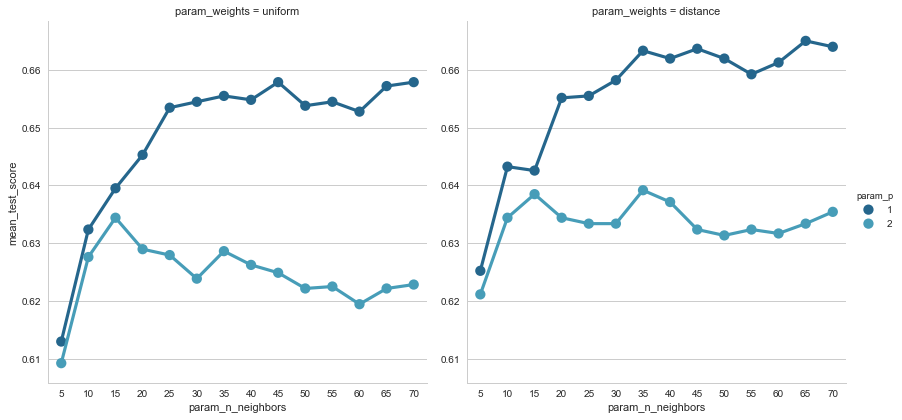

In [22]:
df_results = pd.DataFrame(neigh.cv_results_)[["mean_test_score",
                                              "param_n_neighbors",
                                              "param_p",
                                              "param_weights"]]

sns.set(style="whitegrid")
sns.factorplot(x="param_n_neighbors", y="mean_test_score",
               hue="param_p", col="param_weights", data=df_results,
               capsize=.2, palette="YlGnBu_d", size=6, aspect=1)
plt.show()


** Figure 002:**   Visualisation des résultats de la validation croisée effectuée sur notre classifier multi-classe KNN.

In [23]:
print(f"Le score d'un classifieur KNN est de" 
      f" {round(neigh.score(X_test, y_test), 4) * 100} %")

Le score d'un classifieur KNN est de 66.19 %


### Utilisation d'un algorithme de classification multi-class LogisticRegression : ### 

In [24]:
lr = LogisticRegression(max_iter=500)
params_lr = {'C': np.logspace(-3, 1, 10) , 
             'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
log_reg = GridSearchCV(lr, params_lr, cv=5, scoring="accuracy", return_train_score=True)
log_reg.fit(X_train,y_train)
print(f"Le meilleur résultat est obtenu pour {log_reg.best_params_}")

Le meilleur résultat est obtenu pour {'C': 1.2915496650148828, 'penalty': 'l1', 'solver': 'liblinear'}


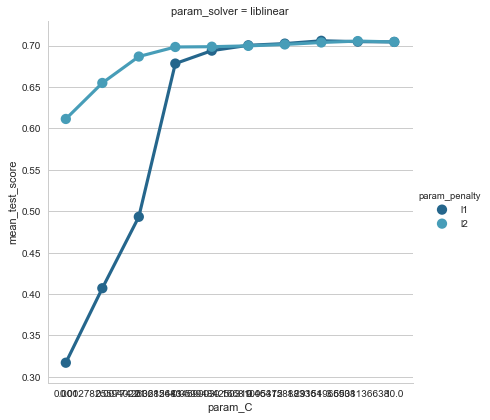

In [25]:
df_results = pd.DataFrame(log_reg.cv_results_)[["mean_test_score",
                                                "param_C",
                                                "param_penalty",
                                                "param_solver"]]
sns.factorplot(x="param_C", y="mean_test_score", hue="param_penalty", 
               col="param_solver", data=df_results, capsize=.2, 
               palette="YlGnBu_d", size=6, aspect=1)
plt.show()

** Figure 003:**   Visualisation des résultats de la validation croisée effectuée sur notre régression logistique.

In [26]:
print(f"Le score d'un classifieur de type régression logistique"
      f" est de {round(log_reg.score(X_test,y_test), 4) * 100} %")

Le score d'un classifieur de type régression logistique est de 67.46 %


### Utilisation d'un algorithme Support Vector Classifier: ###

In [27]:
svc = LinearSVC(dual=False)
params_svc = {'C': np.logspace(-3, 1, 8), 
              'penalty': ['l1','l2'], 'loss': ['squared_hinge']}
sv_classifier = GridSearchCV(svc, params_svc, cv=5,
                             scoring="accuracy", return_train_score=True)
sv_classifier.fit(X_train,y_train)
print(f"Le meilleur résultat est obtenu pour {sv_classifier.best_params_}")

Le meilleur résultat est obtenu pour {'C': 10.0, 'loss': 'squared_hinge', 'penalty': 'l1'}


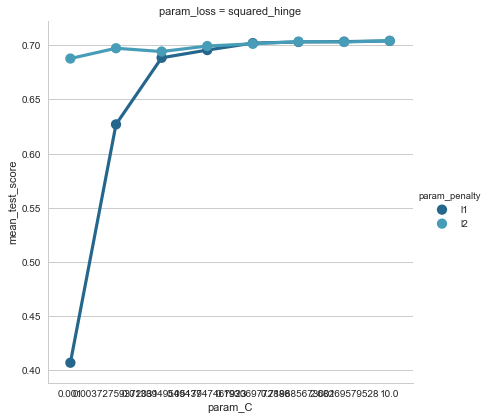

In [28]:
df_results = pd.DataFrame(sv_classifier.cv_results_)[["mean_test_score",
                                                      "param_C",
                                                      "param_penalty",
                                                      "param_loss"]]
sns.factorplot(x="param_C", y="mean_test_score", hue="param_penalty", 
               col="param_loss", data=df_results, capsize=.2,
               palette="YlGnBu_d", size=6, aspect=1)
plt.show()

** Figure 004:**   Visualisation des résultats de la validation croisée effectuée de notre algorithme SVC.

In [29]:
print(f"Le score d'un classifieur de type support vecteur"
      f" est de {round(sv_classifier.score(X_test,y_test), 4) * 100} %")

Le score d'un classifieur de type support vecteur est de 67.78 %


### Utilisation d'un algorithme de classification multi-classe de type Gradient Boosting :  ###

In [30]:
gbc = GradientBoostingClassifier()
params_gbc = {'learning_rate': np.logspace(-3, 0, 4), 'n_estimators': [10, 100, 300],\
              'max_depth': [2,3]}
gbc_classifier = GridSearchCV(gbc, params_gbc, cv=5, 
                              scoring = "accuracy",
                              return_train_score = True)
gbc_classifier.fit(X_train,y_train)
print(f"Le meilleur résultat est obtenu pour {gbc_classifier.best_params_}")

Le meilleur résultat est obtenu pour {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300}


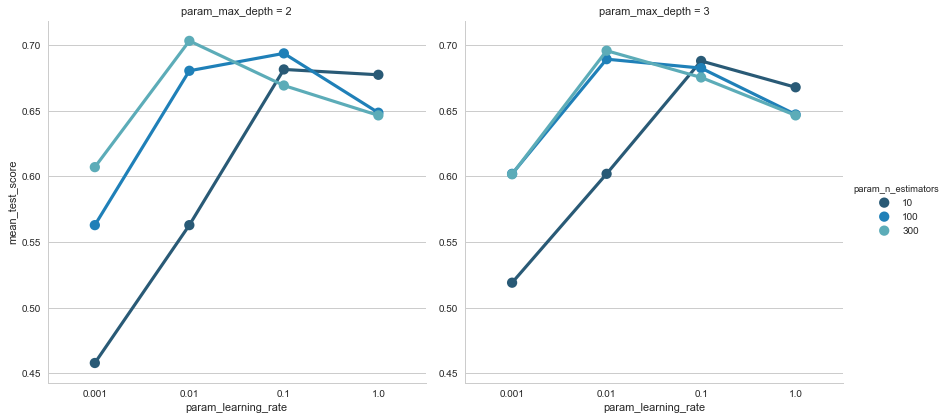

In [31]:
df_results = pd.DataFrame(gbc_classifier.cv_results_)[["mean_test_score",
                                                       "param_learning_rate",
                                                       "param_n_estimators",
                                                       "param_max_depth"]]
sns.factorplot(x="param_learning_rate", y="mean_test_score", 
               hue="param_n_estimators", col="param_max_depth", 
               data=df_results, capsize=.2, palette="YlGnBu_d", 
               size=6, aspect=1)
plt.show()


** Figure 005:**   Visualisation des résultats de la validation croisée effectuée de notre algorithme gradient boosting classifier.

In [32]:
print(f"Le score d'un classifieur de type gradient boosting"
      f" est de {round(gbc_classifier.score(X_test,y_test), 4) * 100} %")

Le score d'un classifieur de type gradient boosting est de 68.17 %


### Vote à la majorité ###

Nous allons combiné les votes des différents classifieur utilisés en utilisant la fonction VotingClassifier de sklearn. Cela nous permettra de combiner les différents classifieurs vu précédemment et de réaliser un vote à la majorité pour renforcer notre prédiciton.

In [33]:
gbc_clf = GradientBoostingClassifier(**gbc_classifier.best_params_)
lr_clf = LogisticRegression(max_iter = 500, **log_reg.best_params_)
svm_clf = LinearSVC(dual=False, **sv_classifier.best_params_)
knn_clf = KNeighborsClassifier(**neigh.best_params_)

In [34]:
vot_clf = VotingClassifier(estimators = [('gbc', gbc_clf),
                                         ('lr', lr_clf),
                                         ('svm', svm_clf)], voting = 'hard')
vot_clf.fit(X_train, y_train)
vot_clf.score(X_test, y_test)

print(f"Le score d'un classifieur de notre classifieur combiné"
      f" est de {round(vot_clf.score(X_test,y_test), 4) * 100} %")

Le score d'un classifieur de notre classifieur combiné est de 67.38 %


Normalized confusion matrix


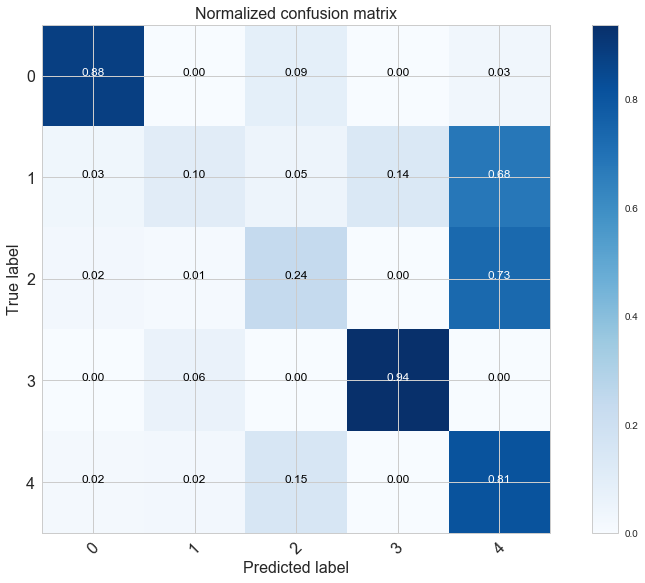

In [35]:
class_names = [0, 1, 2, 3, 4]
y_pred = vot_clf.fit(X_train, y_train).predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix.plot_confusion_matrix(cnf_matrix, classes=class_names,
    #                  title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(12, 8))
plot_function.plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

**Figure 006: ** Matrice de confusion des résultats obtenus par notre classifieur combiné à partir des features du premier achat.

## Observations et conclusions sur ce premier modèle : ##

Nous pouvons observer dans ce premier modèle que la classe 3 (clients étrangers peu nombreux et représentant une faible partie du CA, score à 94%) et la classe 0 (les clients récents ayant fait peu d'achats, score à 88%) obtiennent des performances en prédiction supérieures aux autres sur notre jeu de test. Il peut être intéressant d'utiliser ce premier modèle pour les clients récents car il permettra dès le premier achat de cibler cette catégorie.

On peut également observer la catégorie 1(les clients qui dépensent le plus et le plus souvent) ne sont pas du tout bien prédit avec ce modèle et qu'ils sont confondus avec la catégorie majoritaire, la catégorie 4 (les acheteurs relativement fréquents mais qui dépensent peu par individu au global). De même, la catégorie 2 (les clients perdus) sont confondus avec les clients 4, cela est tout à fait normal car notre premier modèle ne tient pas compte de la fréquence des achats ou de la distance dans le temps au dernier achat.